In [1]:
import torch
import numpy as np
from pathlib import Path
import cv2
import math
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections.abc import Iterable
import matplotlib.pyplot as plt

In [2]:
batch_size=50
patch_size=16
img_size=224
num_patches=(img_size//patch_size)**2
p_dim=768
heads_att=12
num_encoder=11
train_size=0.8

In [3]:
target_class={0:"Normal",1:"Tuberculosis"}
Normal_dir=Path("/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/")
TB_dir=Path("/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/")

In [4]:
Normal_images:list=sorted(list(map(str, list(Normal_dir.glob("*.png")))))
TB_images:list=sorted(list(map(str, list(TB_dir.glob("*.png")))))
Normal_labels:list=[0]*len(Normal_images)
TB_labels:list=[1]*len(TB_images)

In [5]:
images=np.array(Normal_images+TB_images)
labels=np.array(Normal_labels+TB_labels)
images.shape, labels.shape

((4200,), (4200,))

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(images,labels,test_size=1-train_size,random_state=42)
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42)
(x_train.shape,x_valid.shape,x_test.shape)

((3360,), (420,), (420,))

In [7]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(tileGridSize=(8,8),clipLimit=1)
    img=clahe.apply(img)
    img=cv2.GaussianBlur(img,(5,5),0,borderType=cv2.BORDER_CONSTANT)
    img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_LINEAR)
    img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img=(img/255.0).astype(np.float32)
    img=np.moveaxis(img,-1,0)
    return img

In [8]:
x_train=np.array(list(map(image_preprocessing,x_train)))
x_valid=np.array(list(map(image_preprocessing,x_valid)))
x_test=np.array(list(map(image_preprocessing,x_test)))
x_train.shape,x_valid.shape,x_test.shape

((3360, 3, 224, 224), (420, 3, 224, 224), (420, 3, 224, 224))

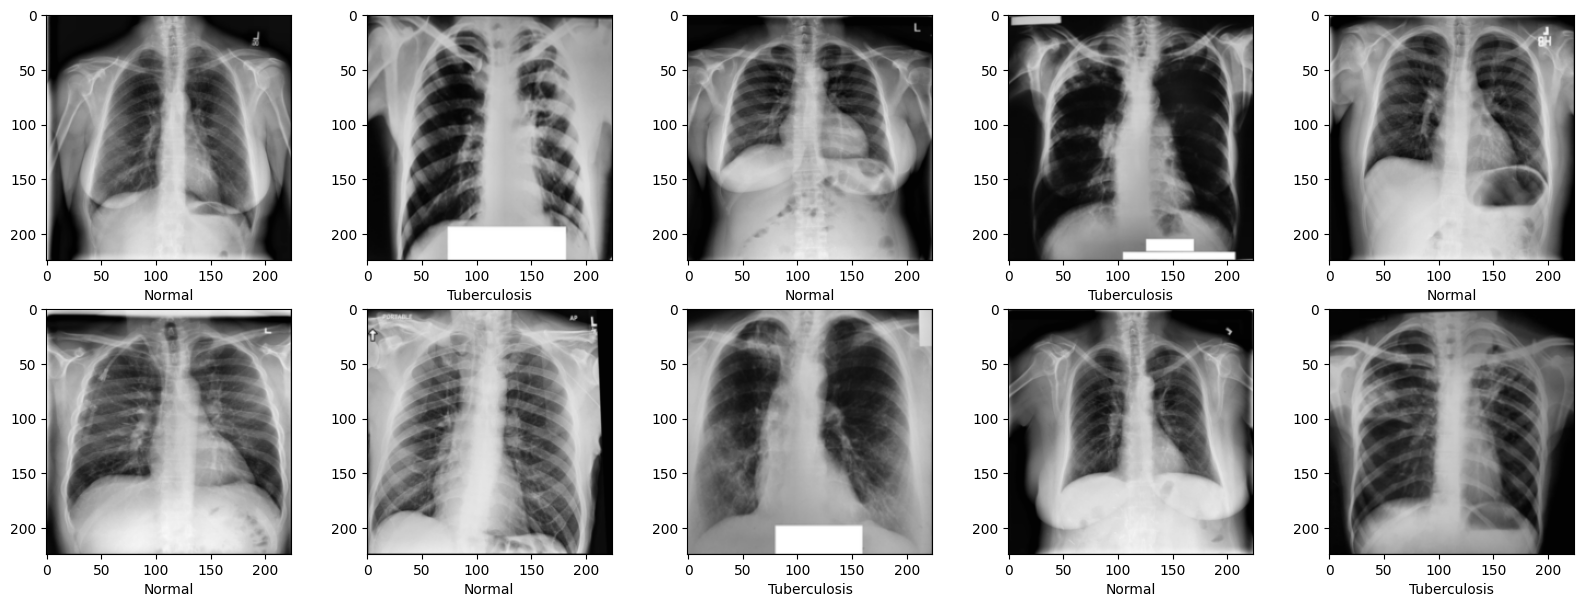

In [9]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    img=np.moveaxis(x_train[i],0,-1)
    ax[i//5,i%5].imshow((img*255).astype('uint8'))
    ax[i//5,i%5].set_xlabel(target_class[y_train[i]])

In [10]:
class StandardScaler():
    def __init__(self) -> None:
        self.mean=None
        self.std=None
        
    def fit(self,tensor:np.ndarray) -> None:
        tensor=tensor.astype(np.float32)
        self.mean=np.mean(tensor,axis=(0,2,3),keepdims=True)
        self.std=np.std(tensor,axis=(0,2,3),keepdims=True)
        
    def transform(self,tensor:np.ndarray) -> np.ndarray:
        scaled=(tensor-self.mean)/(self.std)
        return scaled.astype(np.float32)
    
    def fit_transform(self,tensor:np.ndarray) -> np.ndarray:
        self.fit(tensor=tensor)
        scaled=self.transform(tensor=tensor)
        return scaled

In [11]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)
scaler.mean,scaler.std

(array([[[[0.5223705]],
 
         [[0.5223705]],
 
         [[0.5223705]]]], dtype=float32),
 array([[[[0.25624618]],
 
         [[0.25624618]],
 
         [[0.25624618]]]], dtype=float32))

In [12]:
device=("cuda" if torch.cuda.is_available() else "cpu")
x_train=torch.from_numpy(x_train).to(device)
x_valid=torch.from_numpy(x_valid).to(device)
x_test=torch.from_numpy(x_test).to(device)
y_train=torch.from_numpy(y_train).to(device)
y_valid=torch.from_numpy(y_valid).to(device)
y_test=torch.from_numpy(y_test).to(device)

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [14]:
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_valid,y_valid)
test_dataset=TensorDataset(x_test,y_test)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [15]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, projection_dim:int, num_heads:int, num_patches:int):
        super().__init__()
        self.projection_dim=projection_dim
        self.num_heads=num_heads
        self.num_patches=num_patches

        self.norm1=torch.nn.LayerNorm(self.projection_dim)
        self.norm2=torch.nn.LayerNorm(self.projection_dim)
        self.attention=torch.nn.MultiheadAttention(self.projection_dim,self.num_heads,batch_first=True)
        self.mlp=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,self.projection_dim*4),
            torch.nn.GELU(),
            torch.nn.Linear(self.projection_dim*4,self.projection_dim),
        )

    def forward(self,x):
        x1=self.norm1(x)
        attention=self.attention(x1,x1,x1)[0]
        x2=attention+x
        x3=self.norm2(x2)
        x3=self.mlp(x3)
        out=x2+x3
        return out

In [16]:
class PEG(torch.nn.Module):
    def __init__(self,dim:int,k:int=3):
        super().__init__()
        self.pos=torch.nn.Conv2d(dim,dim,k,1,1,groups=dim)
    def forward(self,x,H,W):
        B,N,C=x.shape
        feat_tokens=x
        feat_tokens=feat_tokens.transpose(1,2).view(B,C,H,W)
        x=self.pos(feat_tokens)+feat_tokens
        x=x.flatten(2).transpose(1,2)
        return x

In [17]:
class Conv2DNormAct(torch.nn.Module):
    def __init__(self,in_chan:int,out_chan:int,kernel:int,stride:int) -> None:
        super().__init__()
        self.block=torch.nn.Sequential(
            torch.nn.Conv2d(in_chan,out_chan,kernel,stride,1),
            torch.nn.BatchNorm2d(out_chan),
            torch.nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)

In [18]:
class ConvStem(torch.nn.Module):
    def __init__(self, 
                 in_chan:Iterable[int], 
                 out_chan:Iterable[int], 
                 kernels:Iterable[int], 
                 strides:Iterable[int], 
                 dim:int, 
                 num_patches:int) -> None:
        super().__init__()
        self.dim=dim
        self.num_patches=num_patches
        self.stem=torch.nn.Sequential()
        for i in range(len(in_chan)):
            self.stem.add_module(f'conv_bn_act_{i}',Conv2DNormAct(in_chan[i],out_chan[i],kernels[i],strides[i]))
        self.stem.add_module('identity_conv',torch.nn.Conv2d(out_chan[-1],dim,1))
    def forward(self,x:torch.Tensor):
        h:torch.Tensor=self.stem(x)
        return h

In [19]:
class ViT(torch.nn.Module):
    def __init__(self,
                 patch_size:int,
                 num_patches:int,
                 projection_dim:int,
                 num_heads:int,
                 num_encoder:int):
        super().__init__()
        self.patch_size=patch_size
        self.num_patches=num_patches
        self.projection_dim=projection_dim
        self.num_heads=num_heads
        self.num_encoder=num_encoder
        
        self.conv_stem=ConvStem([3, 64, 128, 128, 256, 256],
                                [64, 128, 128, 256, 256, 512],
                                [3]*6,
                                [2,2,1,2,1,2],
                                self.projection_dim,
                                self.num_patches)
        self.peg=PEG(self.projection_dim,3)
        self.blocks = torch.nn.ModuleList([
            EncoderBlock(self.projection_dim, self.num_heads, self.num_patches) for _ in range(self.num_encoder)
        ])
        self.ln_out=torch.nn.LayerNorm(self.projection_dim)
        
        self.out=torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim,1),
            torch.nn.Sigmoid()
        )
    def forward(self,images:torch.Tensor):
        batch_size=images.size()[0]
        x=self.conv_stem(images).reshape(batch_size,self.projection_dim,self.num_patches).permute(0, 2, 1)
        encoded=x

        for i,block in enumerate(self.blocks):
            encoded=block(encoded)
            if i==0:
                _H,_W=int(self.num_patches**0.5),int(self.num_patches**0.5)
                encoded=self.peg(encoded,_H,_W)
        
        rep=encoded.mean(dim=1)
        rep=self.ln_out(rep)
        output=self.out(rep)
        return output

In [20]:
model=ViT(patch_size=patch_size,
          num_patches=num_patches,
          projection_dim=p_dim,
          num_heads=heads_att,
          num_encoder=num_encoder)
model=torch.nn.DataParallel(model).to(device)
print(model)

DataParallel(
  (module): ViT(
    (conv_stem): ConvStem(
      (stem): Sequential(
        (conv_bn_act_0): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_act_1): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_act_2): Conv2DNormAct(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (conv_bn_act_

In [21]:
vit_total_params = sum(p.numel() for p in model.parameters())
vit_total_params

80661889

In [22]:
epoch=100
loss_fn=torch.nn.BCELoss()
weight_decay=0.24
opt=torch.optim.AdamW(model.parameters(),lr=1e-5,weight_decay=weight_decay)
#opt=torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt,T_max=epoch,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-05.


In [23]:
best_loss = float('inf')
best_model_weights = None
patience=10
train_losses=[]
val_losses=[]
for i in range(epoch):
    print(f"Epoch: {i+1}\n")
    model.train()
    train_loss=0
    train_batches=len(train_loader)
    for batch,(x,y) in enumerate(train_loader):
        pred=model(x).squeeze(-1)
        loss=loss_fn(pred,y.float())
        train_loss+=loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
    train_loss/=train_batches
    train_losses.append(train_loss)
    print(f"Train Error: \n Avg loss: {train_loss:>8f} \n")
    model.eval()
    val_loss=0
    val_batches=len(val_loader)
    with torch.no_grad():
        for x,y in val_loader:
            pred=model(x).squeeze(-1)
            val_loss += loss_fn(pred,y.float()).item()
    val_loss /= val_batches
    val_losses.append(val_loss)
    print(f"Test Error: \n Avg loss: {val_loss:>8f} \n")
    if val_loss-best_loss<1e-6:
        best_loss=val_loss
        best_model_weights=model.state_dict()
        patience=10
    else:
        patience-=1
        if patience==0:
            break
    scheduler.step()
model.load_state_dict(best_model_weights)
print(f'best loss:', best_loss)

Epoch: 1

Train Error: 
 Avg loss: 0.360928 

Test Error: 
 Avg loss: 0.185648 

Adjusting learning rate of group 0 to 9.9975e-06.
Epoch: 2

Train Error: 
 Avg loss: 0.121032 

Test Error: 
 Avg loss: 0.128920 

Adjusting learning rate of group 0 to 9.9901e-06.
Epoch: 3

Train Error: 
 Avg loss: 0.068690 

Test Error: 
 Avg loss: 0.106257 

Adjusting learning rate of group 0 to 9.9778e-06.
Epoch: 4

Train Error: 
 Avg loss: 0.044815 

Test Error: 
 Avg loss: 0.101905 

Adjusting learning rate of group 0 to 9.9606e-06.
Epoch: 5

Train Error: 
 Avg loss: 0.032399 

Test Error: 
 Avg loss: 0.079337 

Adjusting learning rate of group 0 to 9.9384e-06.
Epoch: 6

Train Error: 
 Avg loss: 0.041824 

Test Error: 
 Avg loss: 0.076678 

Adjusting learning rate of group 0 to 9.9114e-06.
Epoch: 7

Train Error: 
 Avg loss: 0.017816 

Test Error: 
 Avg loss: 0.078955 

Adjusting learning rate of group 0 to 9.8796e-06.
Epoch: 8

Train Error: 
 Avg loss: 0.047731 

Test Error: 
 Avg loss: 0.082087 

Ad

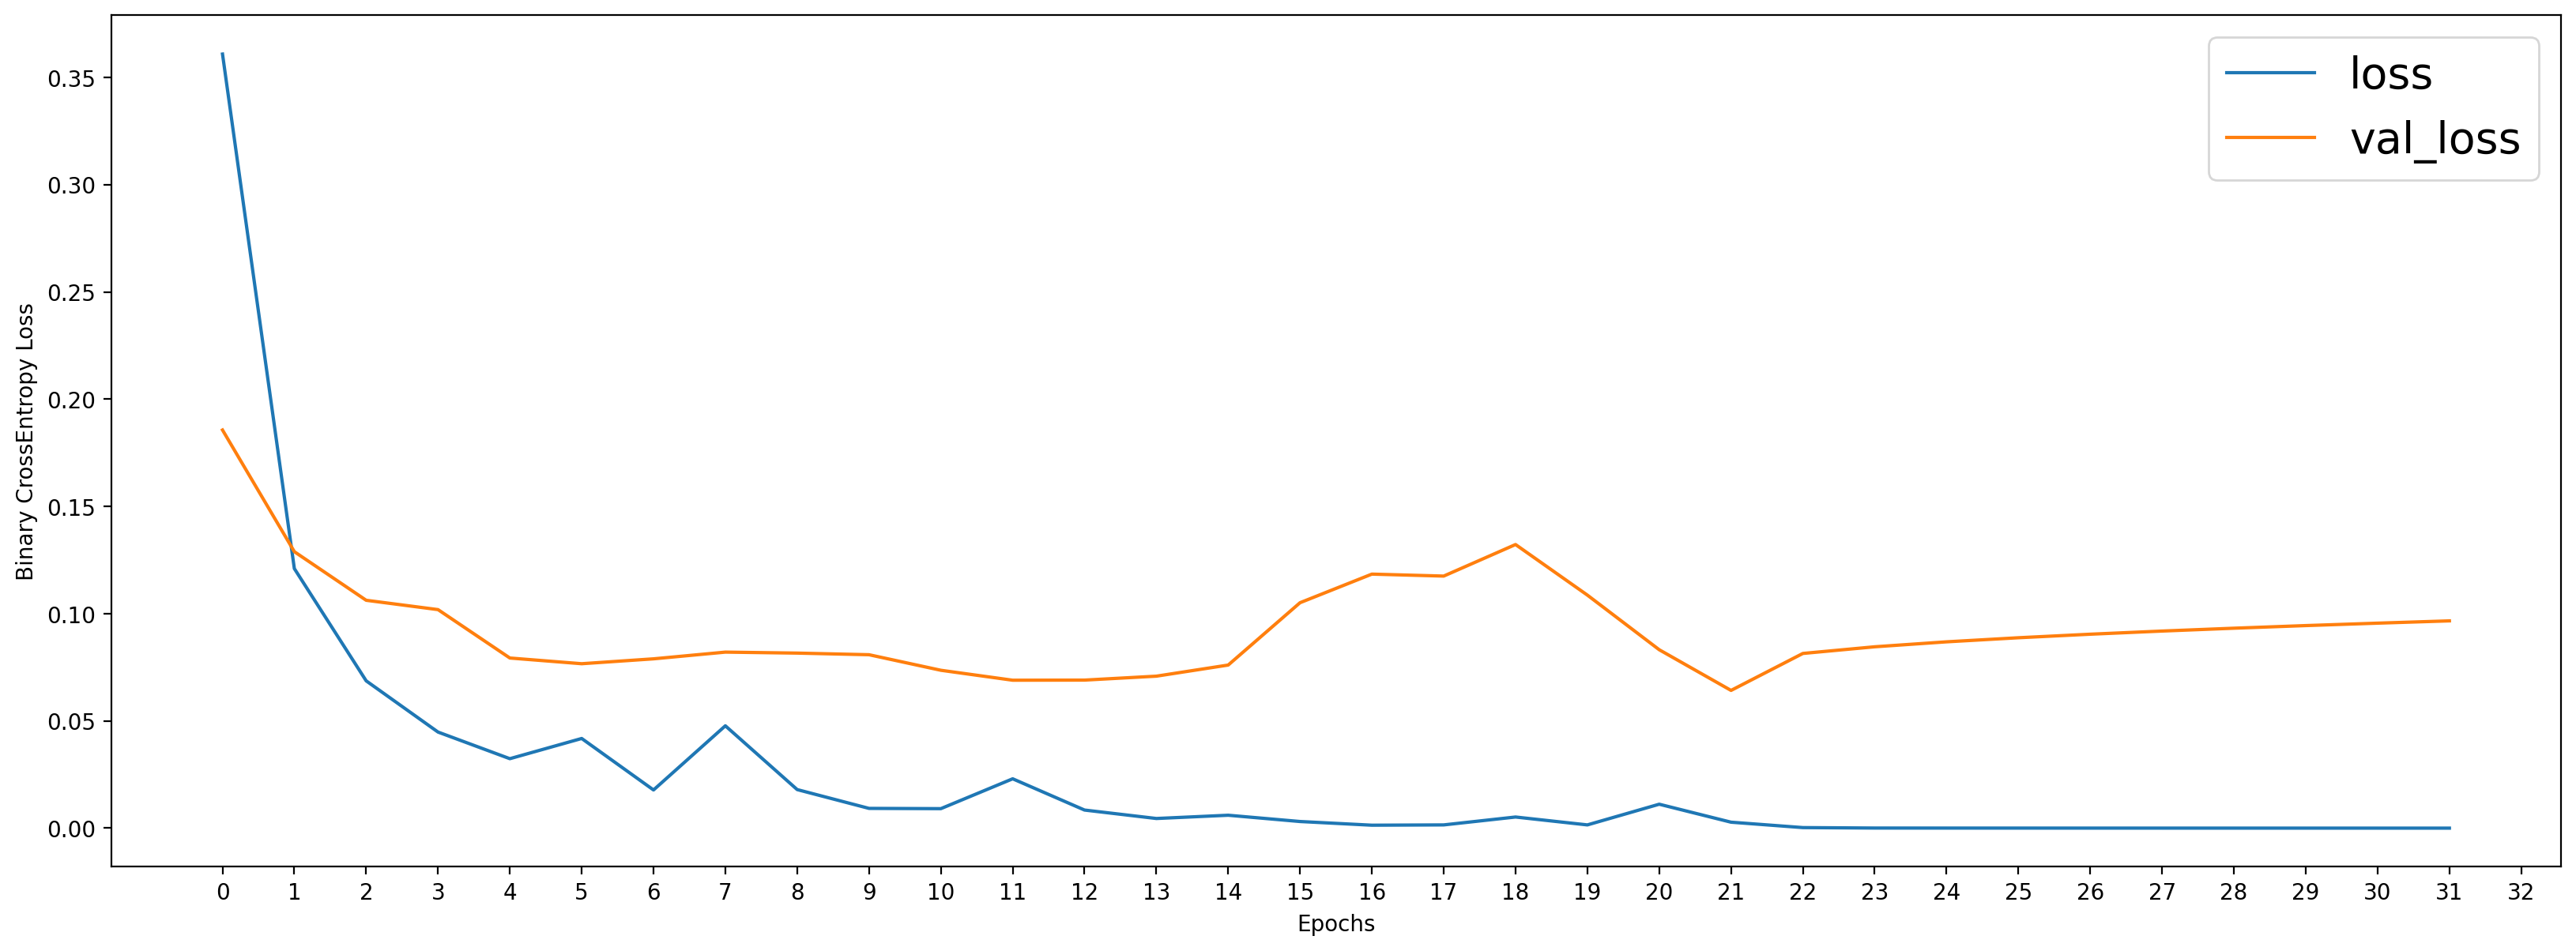

In [24]:
plt.figure(figsize=(20,7),dpi=200)
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.xticks(np.arange(0, len(val_losses)+1, 1))
plt.legend(['loss', 'val_loss'], loc='upper right',fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Binary CrossEntropy Loss')
plt.savefig(f'/kaggle/working/split_{train_size}_AdamW_CPVT_5.png')
plt.show()

In [25]:
model.eval()
val_preds=[]
with torch.no_grad():
    for x,y in val_loader:
        pred=model(x).squeeze(-1)
        val_preds.append(pred.cpu().numpy())
val_preds=np.concatenate(val_preds,axis=0)    
val_preds=np.round(val_preds)
val_scores=(recall_score(y_valid.cpu().numpy(),val_preds),
 accuracy_score(y_valid.cpu().numpy(),val_preds),
 f1_score(y_valid.cpu().numpy(),val_preds))

In [26]:
model.eval()
test_preds=[]
with torch.no_grad():
    for x,y in test_loader:
        pred=model(x).squeeze(-1)
        test_preds.append(pred.cpu().numpy())
test_preds=np.concatenate(test_preds,axis=0)    
test_preds=np.round(test_preds)
test_scores=(recall_score(y_test.cpu().numpy(),test_preds),
 accuracy_score(y_test.cpu().numpy(),test_preds),
 f1_score(y_test.cpu().numpy(),test_preds))

In [27]:
f=open(f'/kaggle/working/split_{train_size}_AdamW_CPVT_5.txt','w')
f.write(f'best val loss: {best_loss}')
f.write('\n')
f.write(f'val recall score: {val_scores[0]}')
f.write('\n')
f.write(f'val accuracy score: {val_scores[1]}')
f.write('\n')
f.write(f'val f1 score: {val_scores[2]}')
f.write('\n')
f.write(f'test recall score: {test_scores[0]}')
f.write('\n')
f.write(f'test accuracy score: {test_scores[1]}')
f.write('\n')
f.write(f'test f1 score: {test_scores[2]}')
f.close()

In [28]:
def evaluation_parametrics(name,y_val, y_pred):
    
    print("\n------------------------{}------------------------\n".format(name))

    cm_test = confusion_matrix(y_val, y_pred)
    class_labels=['Normal','Tuberculosis']
    t1 = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=class_labels)    
    print("\nClassification Report\n")
    print(classification_report(y_val, y_pred))   
    print("--------------------------------------------------------------------------")
    return t1


------------------------Confusion Matrix - Validation Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       349
           1       0.96      0.97      0.97        71

    accuracy                           0.99       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.99      0.99      0.99       420

--------------------------------------------------------------------------


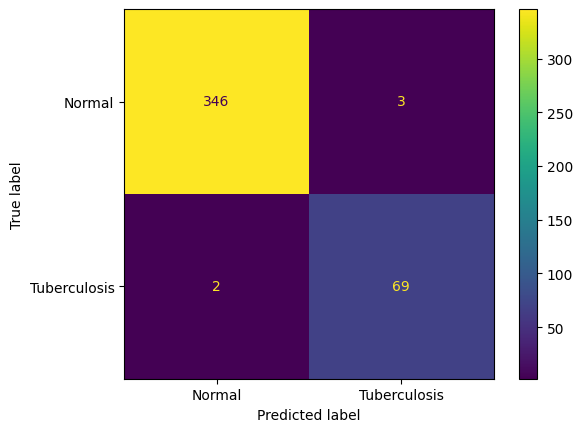

In [29]:
t1=evaluation_parametrics("Confusion Matrix - Validation Dataset", y_valid.cpu().numpy(), val_preds)
t1.plot().figure_.savefig(f'/kaggle/working/valid_AdamW_CPVT_{train_size}_confusion_matrix_5.png')


------------------------Confusion Matrix - Test Dataset------------------------


Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       354
           1       0.97      0.94      0.95        66

    accuracy                           0.99       420
   macro avg       0.98      0.97      0.97       420
weighted avg       0.99      0.99      0.99       420

--------------------------------------------------------------------------


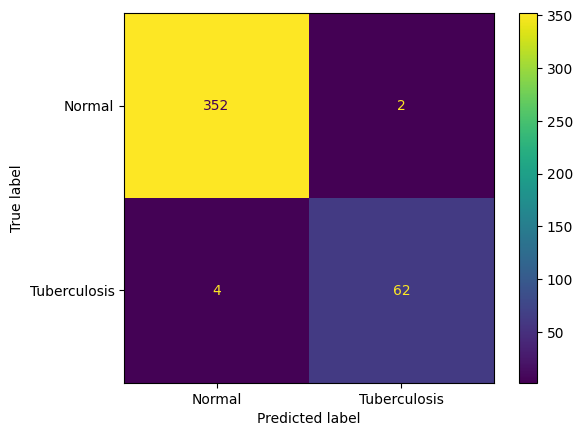

In [30]:
t1=evaluation_parametrics("Confusion Matrix - Test Dataset", y_test.cpu().numpy(), test_preds)
t1.plot().figure_.savefig(f'/kaggle/working/test_AdamW_CPVT_{train_size}_confusion_matrix_5.png')